In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt

from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import GlobalMaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
train = pd.read_csv('csv/train.csv')
valid = pd.read_csv("csv/test.csv")

In [3]:
train.head()

,title,description,plot,csm_review,need_to_know,par_rating,kids_rating,csm_rating,Author,Genre,...,Publisher's recommended age(s),Number of pages,Available on,Last updated,Illustrator,Authors,Awards,Publishers,Award,Illustrators
0,"Bloodhound: Beka Cooper, Book 2",Second book in fantasy series is more mature t...,"BLOODHOUND finds young policewoman -- aka ""Dog...","Like its predecessor, Terrier, Bloodhound is m...",Parents need to know that this fantasy/crime s...,13.0,12.0,12,Tamora Pierce,Fantasy,...,12 - 17,550.0,NaN,"June 19, 2019",NaN,NaN,NaN,NaN,NaN,NaN
1,"The School for Good and Evil, Book 1",Fractured fairy tale has plenty of twists for ...,When best friends Sophie and Agatha are stolen...,The School for Good and Evil is no run-of-the-...,Parents need to know that The School for Good ...,11.0,11.0,8,Soman Chainani,Fairy Tale,...,8 - 17,496.0,"Nook, Audiobook (unabridged), Hardback, iBooks...","October 18, 2017",Iacopo Bruno,NaN,NaN,NaN,NaN,NaN
2,"Twilight: The Twilight Saga, Book 1",Overlong but engrossing popular vampire romance.,"When her mother gets remarried, Bella Swan mov...",This incredibly long book is really two books....,"Parents need to know that, while very mild by ...",13.0,11.0,13,Stephenie Meyer,Fantasy,...,12,498.0,NaN,"February 07, 2020",NaN,NaN,NaN,NaN,NaN,NaN
3,The Lost Girl,"Engrossing story of an ""echo"" designed to repl...","Eva, a teen living in England, has human-like ...",Sangu Mandanna's debut novel is inspired by Fr...,Parents need to know that The Lost Girl is the...,13.0,12.0,14,Sangu Mandanna,Science Fiction,...,13 - 18,432.0,"Nook, Hardback, iBooks, Kindle","June 19, 2019",NaN,NaN,NaN,NaN,NaN,NaN
4,"Warcross, Book 1",Winning teen girl drives cyberpunk virtual rea...,"As WARCROSS opens, bounty hunter Emika Chen fi...","Cyberpunk fell out of favor for a while, but t...",Parents need to know that Warcross is the firs...,14.0,13.0,13,Marie Lu,Science Fiction,...,NaN,368.0,"Nook, Audiobook (unabridged), Hardback, iBooks...","December 05, 2019",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.loc[1, "description"]

'Fractured fairy tale has plenty of twists for fantasy fans.'

## Create the splits

In [5]:
x_tr, y_tr = train['description'].values, train['csm_rating'].values
x_val, y_val = valid["description"].values, valid["csm_rating"].values

In [6]:
print(x_tr.shape, y_tr.shape)

(4651,) (4651,)


In [7]:
print(x_val.shape, y_val.shape)

(1164,) (1164,)


## Prepare the Data

In [8]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

14
3


In [9]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=14)
x_val_seq = pad_sequences(x_val_seq, maxlen=14)
print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

14
14


In [10]:
x_tr_seq[1]

array([   0,    0,    0,    0, 1028,   99,    3,   25,  618,    1,  334,
          8,   12,   72], dtype=int32)

In [11]:
max_length = len(max(x_tr_seq, key=len))

In [12]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

5815


## Create embeddings

In [13]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 5814 unique tokens.


## Create the Model

In [14]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=max_length,trainable=True)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Adding callbacks
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)  
#mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 300)           1744500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 128)           219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,972,469
Trainable params: 1,972,469
Non-trainable params: 0
_________________________________________________________________
None


## Callbacks

In [15]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fit the Model

In [16]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=50,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

/home/evan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4651 samples, validate on 1164 samples
Epoch 1/50
4651/4651 [==============================] - 3s 565us/step - loss: 25.8505 - mae: 4.0834 - val_loss: 14.3923 - val_mae: 3.2197
Epoch 2/50
4651/4651 [==============================] - 2s 450us/step - loss: 12.2786 - mae: 2.9056 - val_loss: 11.5601 - val_mae: 2.7972
Epoch 3/50
4651/4651 [==============================] - 2s 452us/step - loss: 7.0804 - mae: 2.1249 - val_loss: 6.9257 - val_mae: 2.0996
Epoch 4/50
4651/4651 [==============================] - 2s 448us/step - loss: 5.1953 - mae: 1.7960 - val_loss: 6.8251 - val_mae: 2.0693
Epoch 5/50
4651/4651 [==============================] - 2s 450us/step - loss: 4.0814 - mae: 1.5762 - val_loss: 6.6576 - val_mae: 1.9976
Epoch 6/50
4651/4651 [==============================] - 2s 453us/step - loss: 3.4531 - mae: 1.4415 - val_loss: 6.5509 - val_mae: 1.9533
Epoch 7/50
4651/4651 [==============================] - 2s 481us/step - loss: 3.0443 - mae: 1.3313 - val_loss: 7.2465 - val_mae: 2.0

In [17]:
#evaluation 
val_loss, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 0s 192us/step
The val_mae is 2.017.


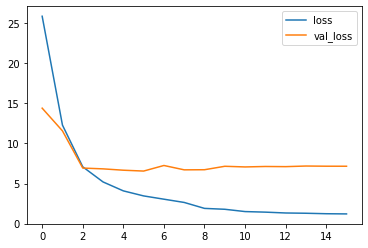

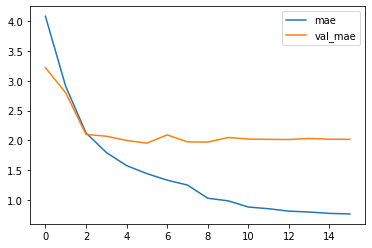

In [18]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();

## [Use Transfer Learning](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)

In [19]:
# load the whole embedding into memory
embeddings_index = dict()

with open("glove/glove.6B.300d.txt") as f:

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [20]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
model=Sequential()

#embedding layer
#model.add(Embedding(size_of_vocabulary,300,input_length=14,trainable=True)) 
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=max_length,trainable=False)) 


#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 300)           1744500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 128)           219648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,972,469
Trainable params: 227,969
Non-trainable params: 1,744,500
_________________________________________________________________
None


In [22]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=50,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

Train on 4651 samples, validate on 1164 samples
Epoch 1/50
4651/4651 [==============================] - 2s 434us/step - loss: 18.7263 - mae: 3.4237 - val_loss: 10.3873 - val_mae: 2.6082
Epoch 2/50
4651/4651 [==============================] - 1s 287us/step - loss: 7.8020 - mae: 2.2269 - val_loss: 8.2311 - val_mae: 2.2712
Epoch 3/50
4651/4651 [==============================] - 1s 313us/step - loss: 7.1555 - mae: 2.1186 - val_loss: 6.9163 - val_mae: 2.0929
Epoch 4/50
4651/4651 [==============================] - 2s 375us/step - loss: 6.7007 - mae: 2.0502 - val_loss: 6.9179 - val_mae: 2.0814
Epoch 5/50
4651/4651 [==============================] - 2s 326us/step - loss: 6.2055 - mae: 1.9615 - val_loss: 7.0022 - val_mae: 2.0863
Epoch 6/50
4651/4651 [==============================] - 1s 304us/step - loss: 6.0209 - mae: 1.9279 - val_loss: 7.4680 - val_mae: 2.1598

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
4651/4651 [==============================]

In [23]:
#evaluation 
_, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 0s 193us/step
The val_mae is 1.887.


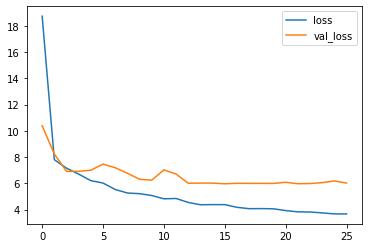

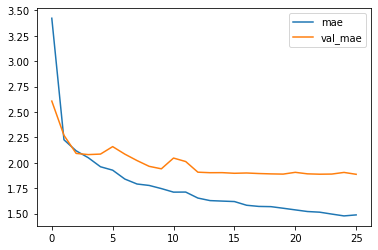

In [24]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();